In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import missingno as msno

In [2]:
def plot_cohorts(
    data,
    title,
    fmt,
    vmin,
    vmax,
    cmap    = "YlGnBu", 
    xlabel  = 'Cohort Month',
    ylabel  = 'Cohort Index',
    figsize = (16, 10),
):
    plt.figure(figsize=figsize)
    
    plt.title(title, fontsize = 14)
    
    # Creating the heatmap
    sns.heatmap(
        data, 
        annot = True,
        vmin  = vmin, 
        vmax  = vmax,
        cmap  = cmap, 
        fmt   = fmt
    )
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.yticks( rotation='horizontal')
    plt.show()

### Carga y limpieza de datos

In [3]:
transaction_df = pd.read_excel('../datasets/transaction.xlsx')
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


### Comprobando y trabajando con valores faltantes

<Axes: >

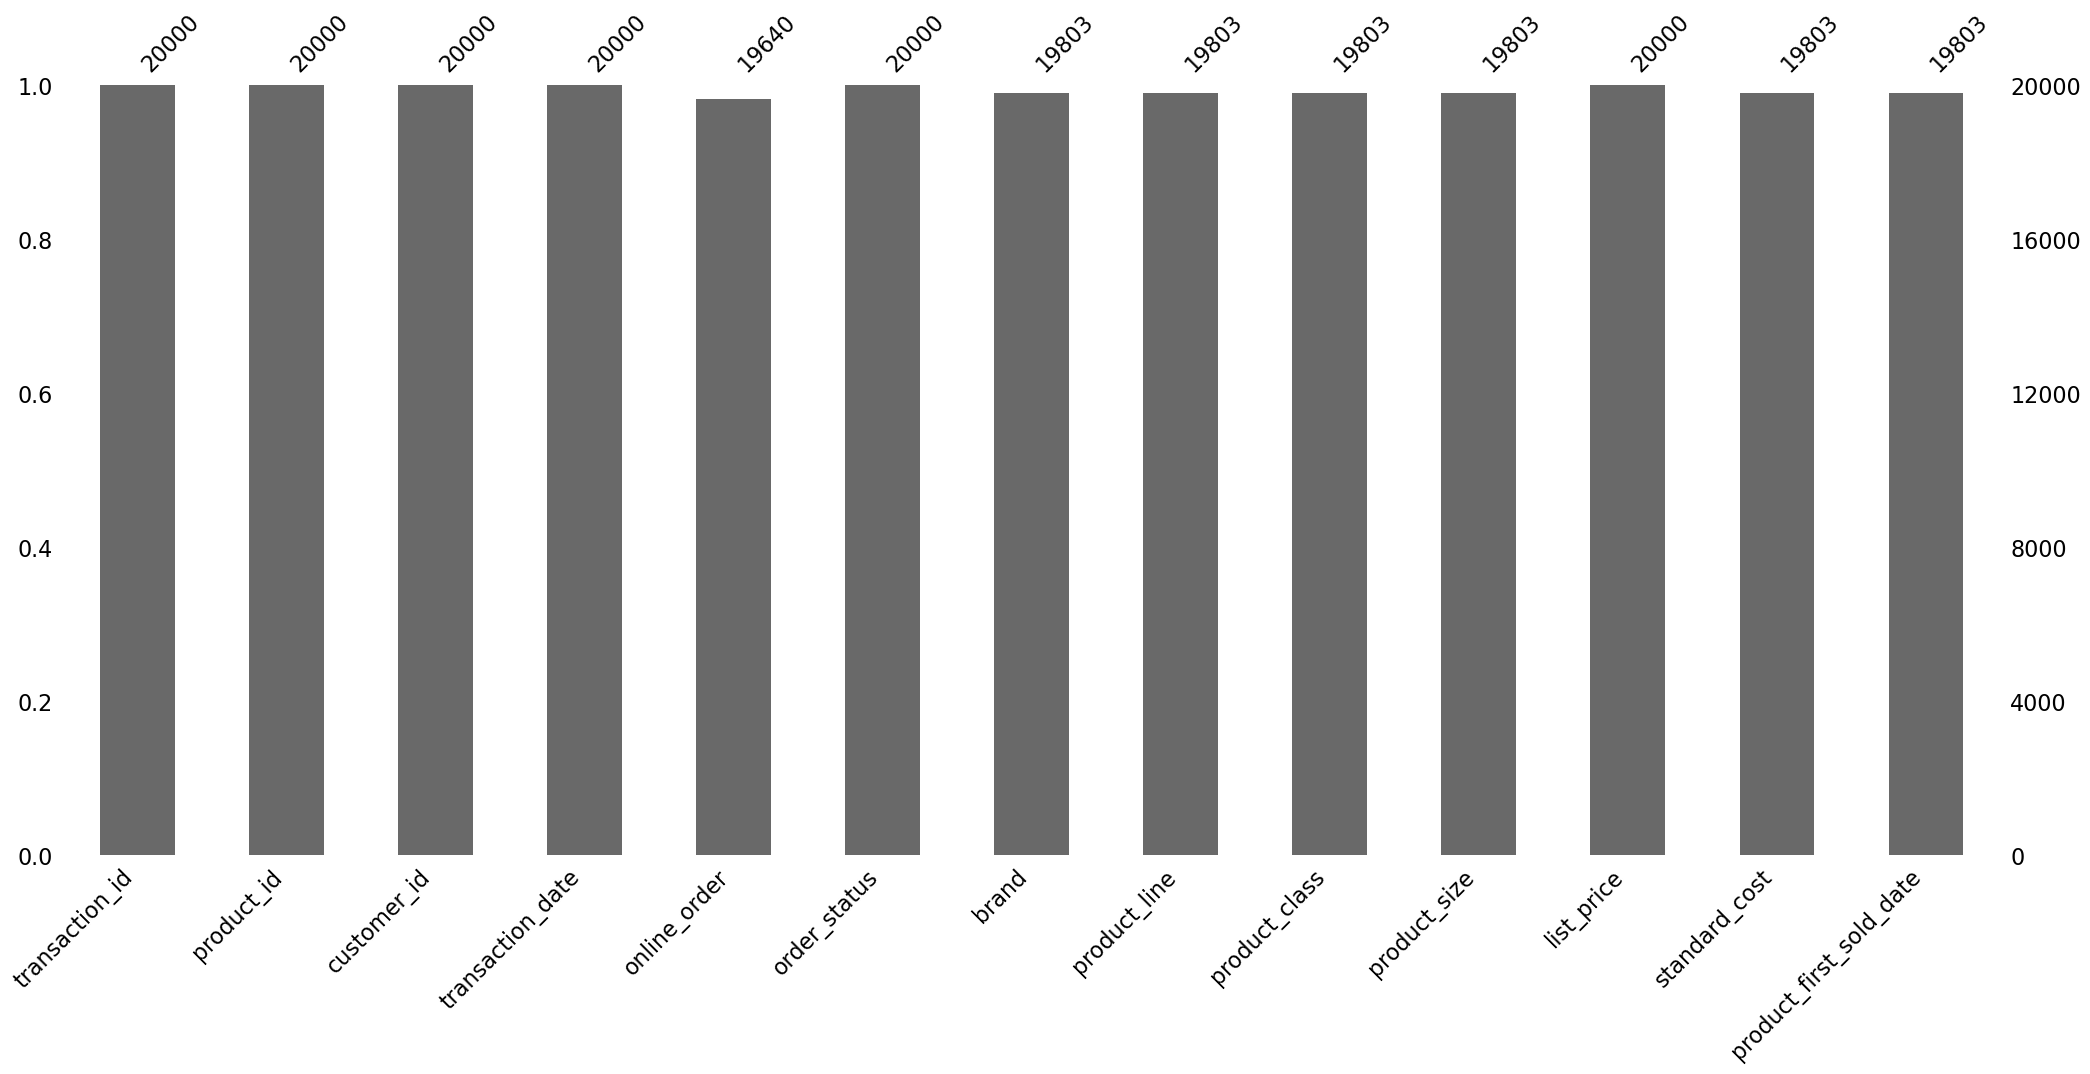

In [4]:
msno.bar(transaction_df)

Aquí, vemos que en cada columna necesitamos tener 20000 datos, pero en las columnas *online_order, brand, product_line, product_class, etc.*, tenemos algunos valores faltantes.

Ahora, a continuación, inspeccionaremos los valores faltantes usando la **función isnull() (missingno e isnull() dan el mismo resultado)**, revisaremos el conjunto de datos y reemplazaremos esos datos con NaN y los imputaremos.

In [5]:
# Inspect missing values in the dataset
print(transaction_df.isnull().values.sum())

# Replace the ' 's with NaN
transaction_df = transaction_df.replace(" ", np.NaN)

# Seleccionar solo las columnas numéricas
numerical_cols = transaction_df.select_dtypes(include=['number']).columns

# Imputar los valores faltantes con la media de las columnas numéricas
transaction_df[numerical_cols] = transaction_df[numerical_cols].fillna(transaction_df[numerical_cols].mean())

# Count the number of NaNs in the dataset to verify
transaction_df.isnull().values.sum()

1542

788

In [6]:
for col in transaction_df.columns:
    # Check if the column is of object type
    if transaction_df[col].dtypes == 'object':
        # Impute with the most frequent value
        transaction_df[col] = transaction_df[col].fillna(transaction_df[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
transaction_df.isnull().values.sum()

0

<Axes: >

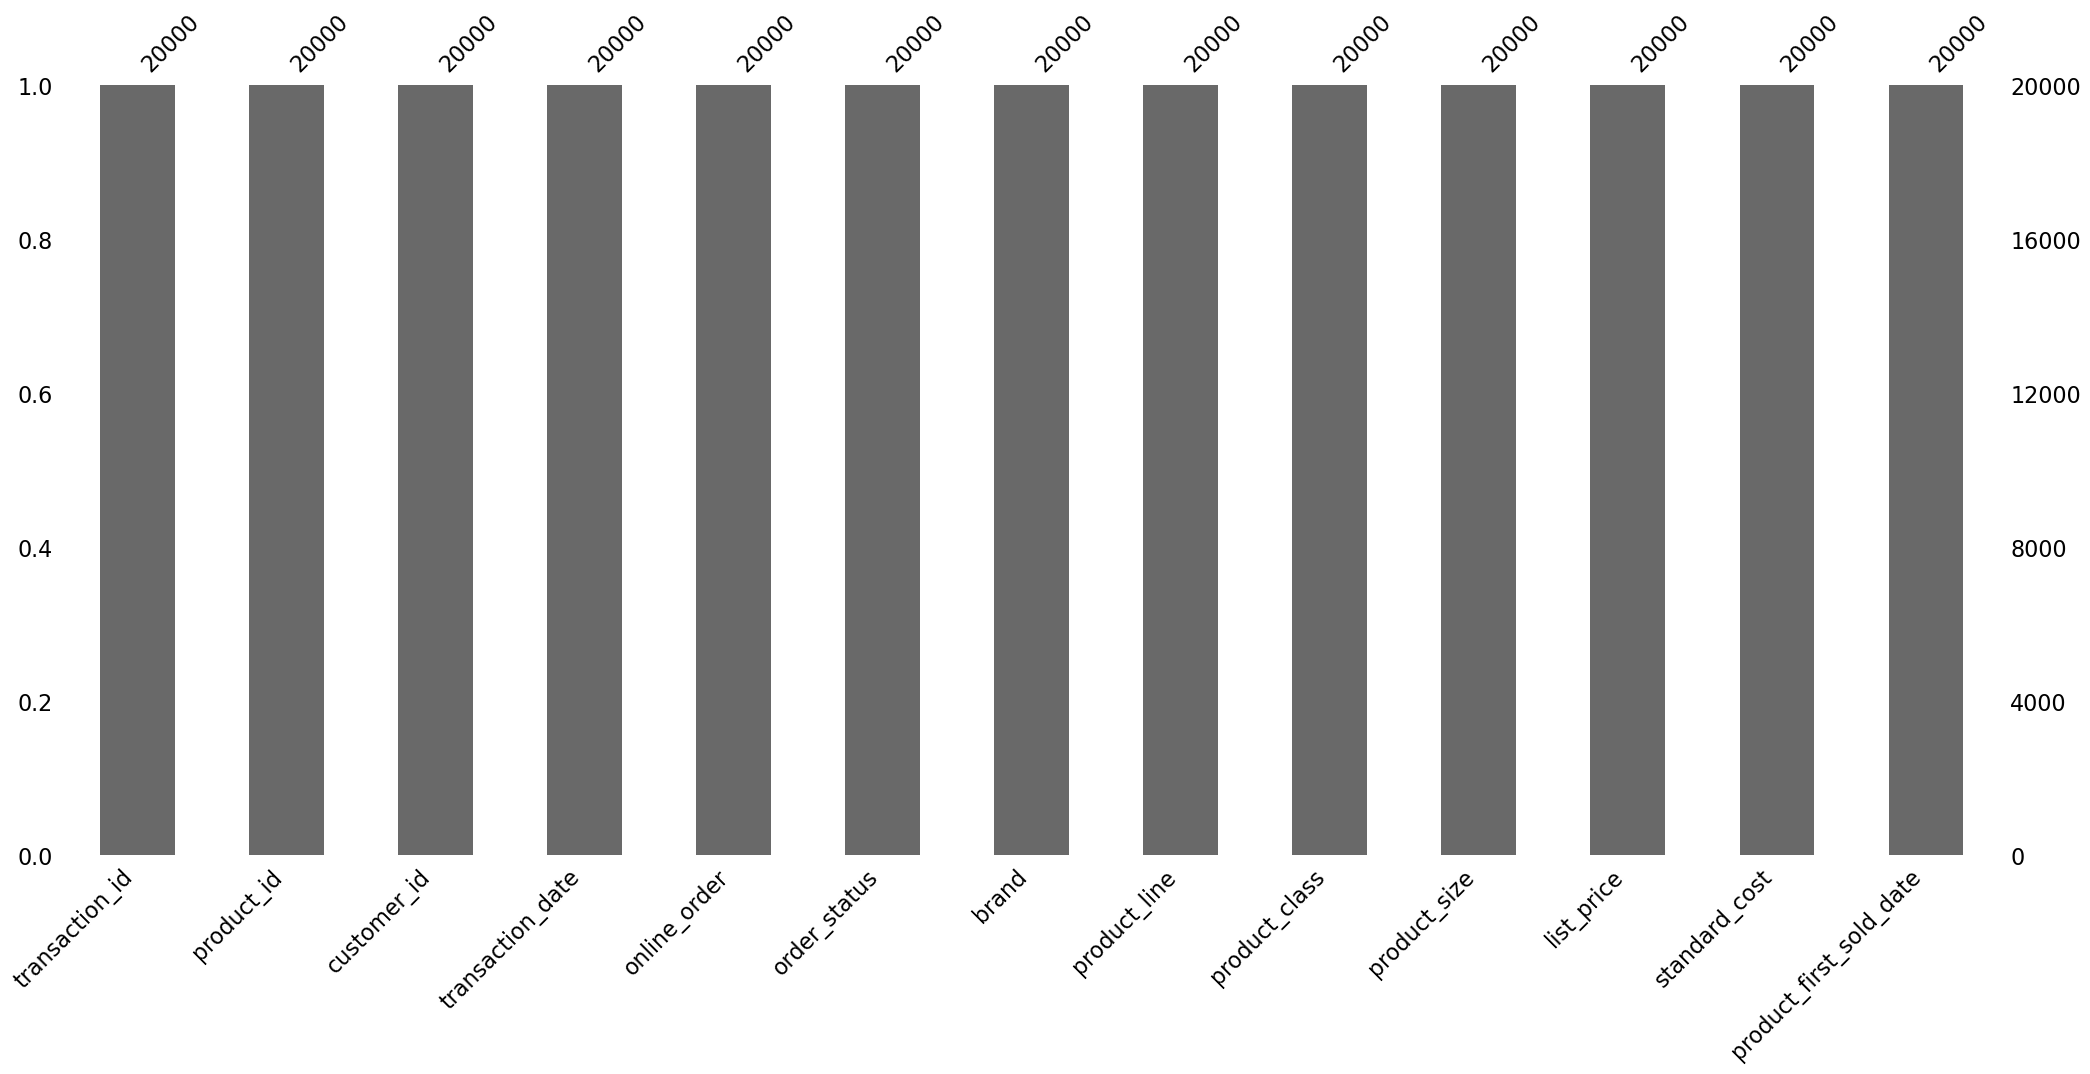

In [7]:
msno.bar(transaction_df)

Ahora vemos que no tenemos ningún valor faltante.

In [8]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             20000 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    20000 non-null  object        
 7   product_line             20000 non-null  object        
 8   product_class            20000 non-null  object        
 9   product_size             20000 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            20000 non-null  float64       
 12  product_first_sold_date  20000 n

Aquí vemos que tenemos 12 columnas (atributos) y 20,000 puntos de datos en el conjunto de datos.

Tenemos 'transaction_date' en formato de fecha y hora.

### Asignación los grupos y calculo de desfase mensual

In [9]:
# A function that will parse the date Time based cohort:  1 day of month
def get_month(x): return dt.datetime(x.year, x.month, 1) 

# Create transaction_date column based on month and store in TransactionMonth
transaction_df['TransactionMonth'] = transaction_df['transaction_date'].apply(get_month) 

# Grouping by customer_id and select the InvoiceMonth value
grouping = transaction_df.groupby('customer_id')['TransactionMonth']

grouping.transform('min').shape

(20000,)

In [10]:
# Assigning a minimum InvoiceMonth value to the dataset
transaction_df['CohortMonth'] = grouping.transform('min')

# printing top 5 rows
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,TransactionMonth,CohortMonth
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,2017-02-01,2017-02-01
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,2017-05-01,2017-01-01
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,2017-10-01,2017-01-01
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,2017-08-01,2017-02-01
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,2017-10-01,2017-01-01


**Calculando el desfase de tiempo en meses como Índice de Cohorte**

Calcular el desfase de tiempo para cada transacción te permite evaluar las métricas de cada cohorte de una manera comparable.

Primero, crearemos 6 variables que capturen el valor entero de años, meses y días para la Fecha de Transacción y la Fecha de Cohorte utilizando la función get_date_int().

In [11]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Getting the integers for date parts from the `InvoiceDay` column
transcation_year, transaction_month, _ = get_date_int(transaction_df, 'TransactionMonth')

# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(transaction_df, 'CohortMonth')


Ahora haremos lo siguiente:
- Calcularemos la diferencia entre TransactionMonth y CohortMonth en años y meses por separado.
- Luego calcularemos la diferencia total en meses entre las dos.
- Este será nuestro desfase en meses o CohortIndex, que utilizaremos en la siguiente sección para calcular la tasa de retención.

In [12]:
years_diff = transcation_year - cohort_year

months_diff = transaction_month - cohort_month

"""
Calcula la diferencia en meses. 
Se suma 1 al final para que el primer mes se marque como 1 en lugar de 0.
"""

transaction_df['CohortIndex'] = years_diff * 12 + months_diff  + 1 

transaction_df.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,TransactionMonth,CohortMonth,CohortIndex
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,2017-02-01,2017-02-01,1
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,2017-05-01,2017-01-01,5
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,2017-10-01,2017-01-01,10
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,2017-08-01,2017-02-01,7
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,2017-10-01,2017-01-01,10


Aquí, al principio creamos un objeto *groupby()* con *CohortMonth* y *CohortIndex* y lo guardamos como grouping.

Luego, llamamos a este objeto, seleccionamos la columna *customer_id* y calculamos el promedio.

Después, almacenamos los resultados como *cohort_data*. Luego, reiniciamos el índice antes de llamar a la función pivot para poder acceder a las columnas que ahora están almacenadas como índices.

Finalmente, creamos una tabla dinámica pasando 
* *CohortMonth* al parámetro de índice,
* *CohortIndex* al parámetro de columnas,
* *customer_id* al parámetro de valores.

y redondeándolo a 1 decimal, y vemos qué obtenemos.

In [13]:
# Contando los usuarios activos diarios de cada grupo
grouping = transaction_df.groupby(['CohortMonth', 'CohortIndex'])

# Cuenta la cantidad de clientes unicos en cada grupo
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

# De esta forma obtenemos la cantida de cliente que compraron en cada group de cohort.
cohort_data

,CohortMonth,CohortIndex,customer_id
0,2017-01-01,1,1354
1,2017-01-01,2,486
2,2017-01-01,3,508
3,2017-01-01,4,509
4,2017-01-01,5,502
...,...,...,...
73,2017-10-01,2,6
74,2017-10-01,3,8
75,2017-11-01,1,13
76,2017-11-01,2,5


In [14]:
# Asignando nombres de columnas al dataframe creado arriba
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'customer_id')

In [15]:
cohort_counts.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,1354.0,486.0,508.0,509.0,502.0,483.0,518.0,529.0,500.0,531.0,497.0,516.0
2017-02-01,800.0,325.0,298.0,313.0,288.0,298.0,308.0,281.0,329.0,308.0,296.0,NaN
2017-03-01,484.0,167.0,174.0,167.0,182.0,184.0,172.0,212.0,189.0,181.0,NaN,NaN
2017-04-01,336.0,111.0,121.0,153.0,143.0,121.0,142.0,126.0,132.0,NaN,NaN,NaN
2017-05-01,210.0,85.0,81.0,87.0,71.0,74.0,73.0,81.0,NaN,NaN,NaN,NaN
2017-06-01,122.0,45.0,44.0,47.0,46.0,46.0,53.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,77.0,26.0,29.0,32.0,37.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,51.0,19.0,21.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,23.0,7.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calcular métricas de negocio: Tasa de retención

El porcentaje de clientes activos en comparación con el número total de clientes después de un intervalo de tiempo específico se llama tasa de retención.

En esta sección, calcularemos el conteo de retención para cada mes de cohorte emparejado con el índice de cohorte.

Ahora que tenemos el conteo de clientes retenidos para cada *mesCohorte* e *índiceCohorte*, calcularemos la tasa de retención para cada cohorte.

Crearemos una tabla dinámica para este propósito.

In [16]:
# Seleccionamos la primera columna ya que tiene el número de clientes activos en el primer día.
cohort_sizes = cohort_counts.iloc[:,0]

# Dividimos todo por el número de clientes activos en el primer día para calcular la taza de retención.
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [17]:
"""
Esta matriz tiene 2 ejes:  

x - fecha de cohorte (inicio del mes);
y - madurez de la cohorte (en meses)  

cada celda es la cantidad de clientes unicos para (x, y).  
"""

# Convertir la tasa de retención en porcentaje y redondear.
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,100.0,35.9,37.5,37.6,37.1,35.7,38.3,39.1,36.9,39.2,36.7,38.1
2017-02-01,100.0,40.6,37.2,39.1,36.0,37.2,38.5,35.1,41.1,38.5,37.0,NaN
2017-03-01,100.0,34.5,36.0,34.5,37.6,38.0,35.5,43.8,39.0,37.4,NaN,NaN
2017-04-01,100.0,33.0,36.0,45.5,42.6,36.0,42.3,37.5,39.3,NaN,NaN,NaN
2017-05-01,100.0,40.5,38.6,41.4,33.8,35.2,34.8,38.6,NaN,NaN,NaN,NaN
2017-06-01,100.0,36.9,36.1,38.5,37.7,37.7,43.4,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,33.8,37.7,41.6,48.1,31.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,37.3,41.2,33.3,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,30.4,30.4,39.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El dataframe de la tasa de retención representa a los clientes retenidos a través de los cohortes. Podemos interpretarlo de la siguiente manera:
- El valor del índice representa el cohorte
- Las columnas representan el número de meses desde el cohorte actual

Por ejemplo: El valor en CohortMonth 2017-01-01, CohortIndex 1 es 35.9 y representa 35.9% de los clientes de la cohorte 2017-01> que fueron retenidos en el 2er mes,

#### Observaciones:
- La Tasa de Retención del 1er índice, es decir, del 1er mes, es del 100% ya que todos los clientes de ese grupo se registraron en el 1er mes.
- La Tasa de Retención puede aumentar o disminuir en índices posteriores.
- Los valores hacia la esquina inferior derecha tienen muchos valores NaN.

# Visualizando la tasa de retención

Antes de empezar a trazar nuestro mapa de calor, vamos a configurar el índice de nuestro dataframe de tasa de retención a un formato de cadena más legible.

In [18]:
retention.index = retention.index.strftime('%Y-%m')
retention.index


Index(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype='object', name='CohortMonth')

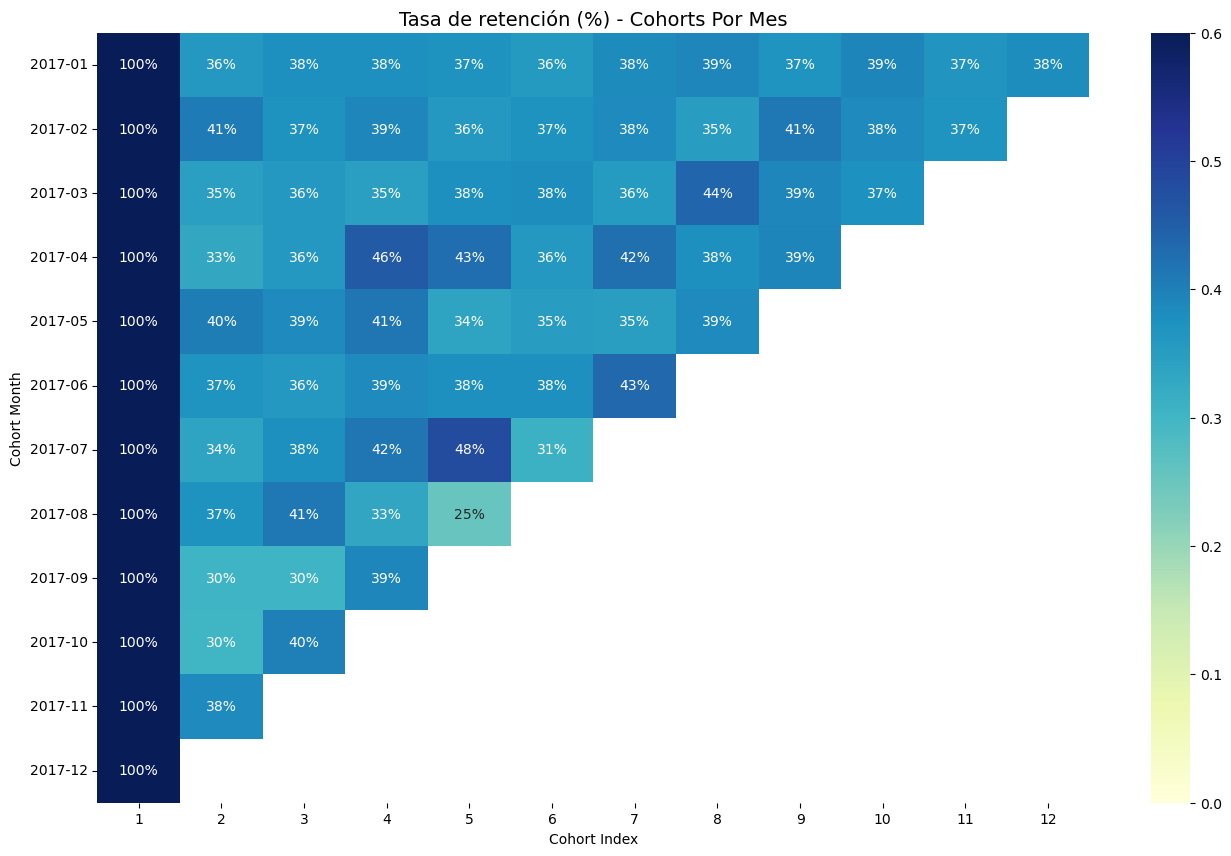

In [19]:
plot_cohorts(
    retention,
    'Tasa de retención (%) - Cohorts Por Mes',
    fmt  = '.0%',
    vmin = 0.0,
    vmax = 0.6
)

### Interpretando la taza de retención

Aquí tenemos 12 cohorts uno para cada mes y 12 índices de cohortes. Cuanto más oscuros sean los tonos de azul, mayores serán los valores. Por lo tanto, si vemos el mes de la cohorte 2017-07 en el índice de la quinta cohorte, vemos el tono azul oscuro con un 48%, lo que significa que el 48 % de las cohortes que compraron en julio de 2017 estaban activas 5 meses después.

De manera similar, podemos realizar análisis de cohortes para otras matrices de negocios. Según nuestro objetivo, veremos **cohorte mensual de precio de lista promedio** y **cohorte mensual de costo estándar promedio**.

### Costo estándar promedio por mes del grupo

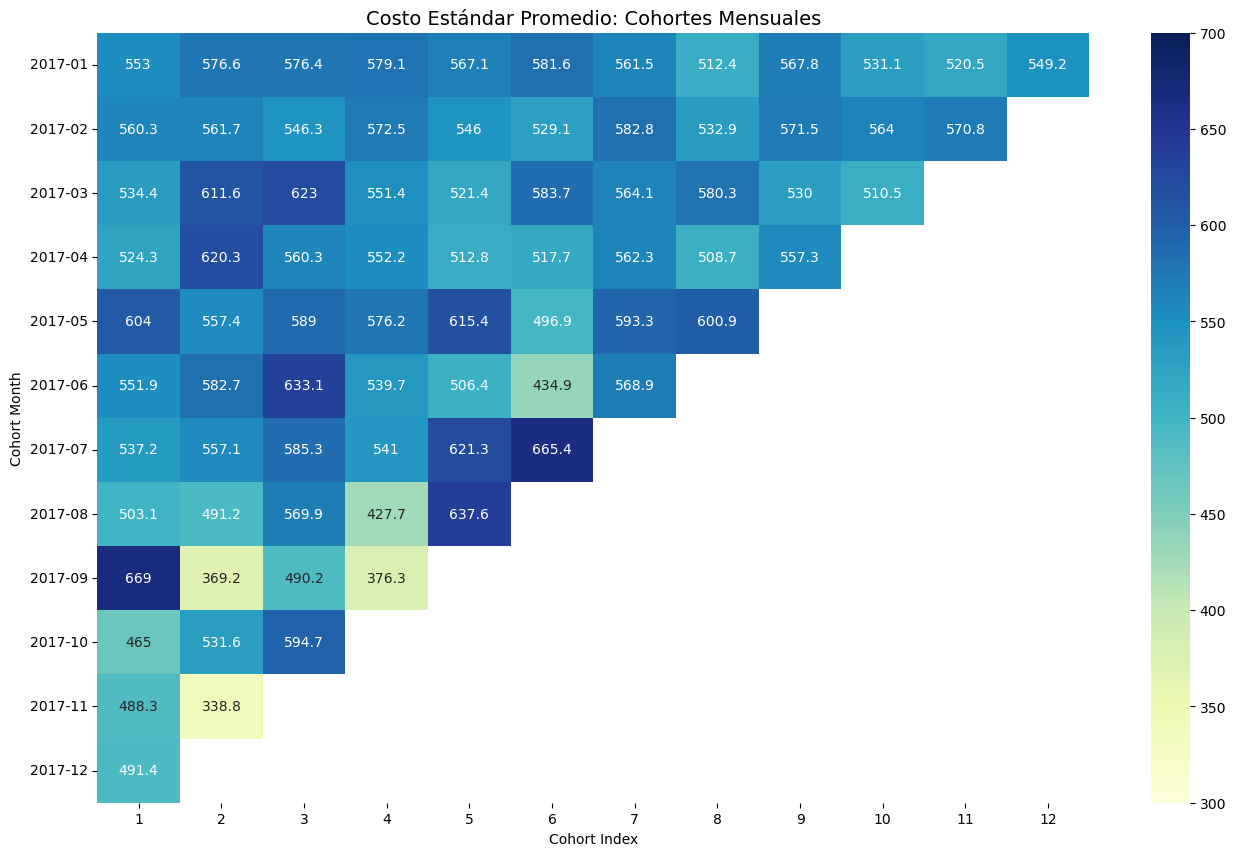

In [29]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = transaction_df.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the standard  average cost of the standard_cost column
cohort_data = grouping['standard_cost'].mean()

# Reset the index of cohort_data before pivot
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_order = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='standard_cost')

average_standard_cost = average_order.round(1)

average_standard_cost.index = average_standard_cost.index.strftime('%Y-%m')

plot_cohorts(
    average_standard_cost,
    'Costo Estándar Promedio: Cohortes Mensuales',
    fmt  = 'g',
    vmin = 300, 
    vmax = 700
)

### Precio promedio de lista por cohorte mensual

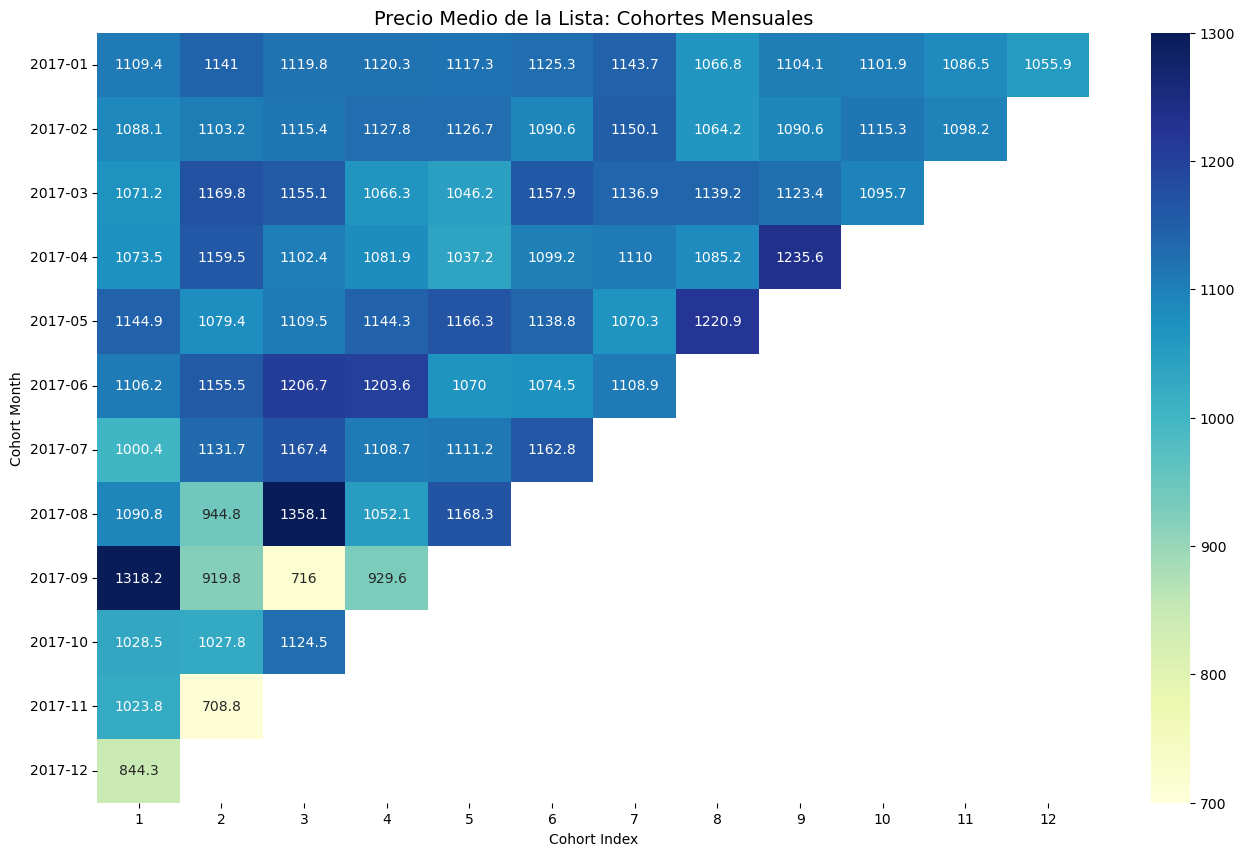

In [27]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = transaction_df.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the list price column
cohort_data = grouping['list_price'].mean()

# Reset the index of cohort_data before pivot
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_list = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='list_price')

average_list_cost = average_list.round(1)

average_list_cost.index = average_list_cost.index.strftime('%Y-%m')

plot_cohorts(
    average_list_cost,
    'Precio Medio de la Lista: Cohortes Mensuales',
    fmt  = 'g',
    vmin = 700, 
    vmax = 1300,
)